In [1]:
import os
import argparse
import tensorflow as tf
from IPython import display
from tensorflow import Tensor
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
import utils  # local import
from model import Generator  # local import

from tqdm import tqdm


2022-04-09 13:53:16.341096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# import zipfile
# with zipfile.ZipFile(os.getcwd() + "/data.zip", 'r') as zip_ref:
#     zip_ref.extractall(os.getcwd() + "/")

In [4]:
EPOCHS = 1
LAMBDA = 100
BATCH_SIZE = 8
IMG_WIDTH = 832
IMG_HEIGHT = 832

# IMG_WIDTH = 256
# IMG_HEIGHT = 256

BUFFER_SIZE = 400
SAVE_PATH = 'weights'
ff_dim = 32
num_heads = 8
patch_size = 26
embed_dim = 128
projection_dim = 64
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_patches = (IMG_HEIGHT // patch_size) ** 2

PATH = os.getcwd() + "/data/"
SAVE_PATH = os.getcwd() + "/modelbin_new/"

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

assert IMG_WIDTH == IMG_HEIGHT, 'width and height must have same size'

device = '/device:GPU:0' if utils.check_cuda else '/cpu:0'



In [5]:
print(num_patches, (IMG_HEIGHT // patch_size))

1024 32


In [6]:

color_map = {}
import pickle
import random
color_map['0'] = (0,0,0,255)
random.seed(20)
for i in range(150, 256):
    color_map[f'{i}'] = [random.randint(0,255), random.randint(0,255), random.randint(0,255), 255]

# pickle.dump(color_map, open("colormap.bin", 'wb'))
# print(pickle.load(open("colormap.bin", 'rb')))
    
def color_helper(pix):
    # print(color_map[f'{pix}'])
    return color_map[f'{pix}']

def colormap_pat(nparray):
    new_image_array = []
    for row in nparray:
        temp_col = []
        for column in row:
            temp_col.append(color_helper(column))
            # print(column, color_helper(column), cm.flag(column))
            
        new_image_array.append(temp_col)
        
        
    return new_image_array



In [54]:


def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


# normalizing the images between [-1, 1]
def normalize(input_image, real_image):
    #TODO FIND OUT IF I NEED TO MAKE OG NORMALIZATION WORK [-1,1] VS [0,1]
#     input_image = (input_image / 127.5) -1
#     real_image = (real_image / 127.5)  -1 

    input_image = (input_image / 255)
    real_image = (real_image / 255)   

    
    return real_image, input_image


def add_noise(input_image, real_image):
    
    
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    #add random color
#     input_image, real_image = add_noise(input_image, real_image)
    
    
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


def load_image_train(image_file):
    print(image_file)
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

0.0


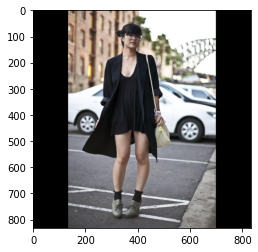

In [58]:
from PIL import Image
from IPython import display as display
from matplotlib.pyplot import imshow

ins, real = load(os.getcwd() + '/data/test/testimage.PNG')

im = ins.numpy()
# print(im[100][0][0])

# im = Image.fromarray(im)
ins, real = normalize(ins, real)
# print(ins.shape)
im = ins.numpy()
print(np.min(im))
# im = Image.fromarray((im * 255).astype(np.uint8))
imshow(im)

In [5]:
tf.config.run_functions_eagerly(False)

train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
    test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.png')
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(BATCH_SIZE)
except:
    test_dataset = train_dataset


2022-03-31 14:40:08.398388: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 14:40:08.399612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-31 14:40:08.615735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: NVIDIA A100-SXM4-80GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.35GiB deviceMemoryBandwidth: 1.85TiB/s
2022-03-31 14:40:08.615773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-31 14:40:08.619684: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-31 14:40:08.619716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

Tensor("args_0:0", shape=(), dtype=string)


In [6]:
# import os
# import zipfile

# with zipfile.ZipFile(os.getcwd() + "/data.zip", 'r') as zip_ref:
#     zip_ref.extractall(os.getcwd())

In [7]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()





def train_step(input_image, target, epoch):
    with tf.device(device):
        with tf.GradientTape() as gen_tape:
            gen_output = generator(input_image, training=True)

            gen_total_loss = tf.reduce_mean(tf.abs(target - gen_output))

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)

        optimizer.apply_gradients(zip(generator_gradients,
                                      generator.trainable_variables))


def fit(train_ds, epochs, test_ds):
    print(f"[INFO] will train on device: {device}")
    for epoch in range(epochs):

        if utils.is_notebook():
            display.clear_output(wait=True)

            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)

        print(f'Epoch: [{epoch}/{epochs}]')

        # Train
        for n, (input_image, target) in tqdm(train_ds.enumerate()):
            train_step(input_image, target, epoch)

        generator.save_weights(f'{SAVE_PATH}/tensor2image-weights.h5')


def test(test_dataset, generator):
    ''' 
    a function to visually inspect to outputs
    '''
    if utils.is_notebook():
        for inp, tar in test_dataset.take(1):
            generate_batch_images(generator, inp, tar)

def generate_batch_images(model, test_input, tar):
#     for i in range(len(test_input)):
    print(tf.shape(test_input))
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))


    pred_np = np.expand_dims(prediction.numpy()[0], 0)
#     masked_im = np.expand_dims(test_input.numpy()[0], 0)

# #     print(np.shape(pred_np), np.shape(masked_im))
#     for i, val in enumerate(pred_np):
#         for j, row in enumerate(val):
#             for k, channel in enumerate(row):
#                 if np.mean(pred_np[i][j][k]) < -0.8:
#                     masked_im[i][j][k] = [0.0,0.0,0.0]

#     masked_im = tf.convert_to_tensor(masked_im)
#     print(tf.shape(masked_im))

#     if tf.shape(masked_im)[0] > 1:
#         masked_im = masked_im[0]



#     masked_im = tf.reshape(masked_im,(256,256,3))
#     display_list = [test_input[i], tar[i], prediction[i], masked_im]
    display_list = [test_input[i], tar[i], prediction[i]]
#         print(prediction)
    title = ['Input Image', 'Ground Truth', 'Predicted Image', 'Masked']

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # converting the pixel values to [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    

In [19]:
generator = Generator(input_shape, patch_size, num_patches, projection_dim, num_heads, ff_dim)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# generator.summary()

optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Shape: KerasTensor(type_spec=TensorSpec(shape=(None, 1024, 64), dtype=tf.float32, name=None), name='transformer_block_19/layer_normalization_39/batchnorm/add_1:0', description="created by layer 'transformer_block_19'")


In [ ]:

generator.load_weights(filepath = os.getcwd() + "/modelbin/tensor2image-weights.h5")

In [ ]:
fit(train_dataset, 50, test_dataset)

In [ ]:
#augment by reverse masking image, adding noise and recombining

In [ ]:
test(train_dataset, generator)

In [ ]:
im = Image.open(os.getcwd() + "/data/beave.png")

In [ ]:
from PIL import Image
import numpy as np
model = generator
# im = Image.open("test30.jpg")
im = Image.open(os.getcwd() + "/data/beave.jpg")
numpydata = np.expand_dims(np.asarray(im), 0)
# print(numpydata[0][0][0])
test_input = tf.convert_to_tensor(numpydata)
# generate_batch_images(generator,tensor,tensor )
tar = test_input

# print(tf.shape(test_input))
prediction = model(test_input, training=True)
plt.figure(figsize=(15, 15))

pred_np = np.expand_dims(prediction.numpy()[0], 0)
masked_im = np.expand_dims(test_input.numpy()[0], 0)

#     print(np.shape(pred_np), np.shape(masked_im))
for i, val in enumerate(pred_np):
    for j, row in enumerate(val):
        for k, channel in enumerate(row):
            if np.mean(pred_np[i][j][k]) < -0.8:
                masked_im[i][j][k] = [0.0,0.0,0.0]

masked_im = tf.convert_to_tensor(masked_im)
# print(tf.shape(masked_im))

if tf.shape(masked_im)[0] > 1:
    masked_im = masked_im[0]


masked_im = tf.reshape(masked_im,(256,256,3))
display_list = [test_input[i], masked_im]
#         print(prediction)
title = ['Input Image', 'Masked']

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # converting the pixel values to [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
plt.show()